# Import libraries

In [97]:
# import requests

# from bs4 import BeautifulSoup

# import time

# import pandas as pd
# import numpy as np

# import re
# from nltk.corpus import stopwords

# from textblob import Word
# from textblob import TextBlob

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# import matplotlib.pyplot as plt
# import seaborn as sns

# from nrclex import NRCLex
# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import TfidfVectorizer

# from wordcloud import WordCloud
# import spacy
# import en_core_web_sm

# nlp = en_core_web_sm.load()

# from collections import Counter
# import itertools
# from nltk.util import ngrams
# import nltk
# # nltk.download('punkt')
# # nltk.download('vader_lexicon')
# from nltk.tokenize import word_tokenize
# from nltk.sentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

# Scraping Tesla customers reviews for 2024 from Trustpilot.com

In [ ]:
url = 'https://www.trustpilot.com/review/www.teslamotors.com?date=last12months' # page 1

r = requests.get(url)

soup = BeautifulSoup(r.text, 'html.parser')

results = soup.findAll(class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')

reviews = []
reviews.append(results)

time.sleep(10 * 60) #10 minuates

# traversing through the remaining pages and scraping customer reviews
# traverse through evry page 1 at a time and scrape reviews if it doesnt work
for i in range(2,6):
     url = f'https://www.trustpilot.com/review/www.teslamotors.com?date=last12months&page={i}'

     r = requests.get(url)

     soup = BeautifulSoup(r.text, 'html.parser')

     results = soup.findAll(class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')

     reviews.append(results)

     time.sleep(10 * 60) #10 minuates

In [ ]:
print(r.status_code)

200


In [ ]:
reviews

[[<p class="typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn" data-service-review-text-typography="true">Same atrocious customer service again and again. Keep cancelling mobile service appointments after making us wait the whole time. There is no way to lodge a complaint, nothing on website, no postal address, no email address, chat is not answered, some manager has to call you back whenever for you to be able to complaint. They do not seem to subscribe to any regulator like Motoring Ombudsman. If they don't allow complaints, cannot escalate the complaint to regulator anyway. This is effectively an unregulated business, which is scandalous. Not sure how they are allowed to exist in the UK or any so called developed country. Completely based on loopholes and I am sure illegal somewhere. Too late if you have already purchased TESLA, beware the others, this is real. Something like a mass legal action is necessary. You don't get to be be the world

In [ ]:
reviews = [result.text for result in results]

In [ ]:
reviews

["Same atrocious customer service again and again. Keep cancelling mobile service appointments after making us wait the whole time. There is no way to lodge a complaint, nothing on website, no postal address, no email address, chat is not answered, some manager has to call you back whenever for you to be able to complaint. They do not seem to subscribe to any regulator like Motoring Ombudsman. If they don't allow complaints, cannot escalate the complaint to regulator anyway. This is effectively an unregulated business, which is scandalous. Not sure how they are allowed to exist in the UK or any so called developed country. Completely based on loopholes and I am sure illegal somewhere. Too late if you have already purchased TESLA, beware the others, this is real. Something like a mass legal action is necessary. You don't get to be be the world's richest by simply obeying the law.",
 "Warning - Tesla Legal Scam. Read this before you take Tesla to court. Tesla has two companies. One is ca

In [ ]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [ ]:
df.head()

,review
0,Same atrocious customer service again and agai...
1,Warning - Tesla Legal Scam. Read this before y...
2,Car is pretty good but the infotainment system...
3,"The 12v battery died, I arranged an appointmen..."
4,Alarm front system fault part of a recall re a...


In [ ]:
df.shape

(12, 1)

In [ ]:
# export to csv
df.to_csv('Telsa Reviews 2024.csv')

In [4]:
df = pd.read_csv(r"C:\Users\Shivan\Downloads\Telsa Reviews 2024.csv")

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,review
0,0,0,Still waiting to hear from customer service s....
1,1,1,"One of the worst car is Tesla, very expensive ..."
2,2,2,I can't understand the fixation that few have ...
3,3,3,"Great car, but the customer service side is sh..."
4,4,4,"I bought a Tesla car 3 Months ago,Unfortunatel..."


In [ ]:
df.shape

(329, 3)

In [ ]:
df.dtypes

Unnamed: 0.1     int64
Unnamed: 0       int64
review          object
dtype: object

In [6]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [7]:
df.head()

,review
0,Still waiting to hear from customer service s....
1,"One of the worst car is Tesla, very expensive ..."
2,I can't understand the fixation that few have ...
3,"Great car, but the customer service side is sh..."
4,"I bought a Tesla car 3 Months ago,Unfortunatel..."


# Data prep

In [29]:
df2 = df.copy()

In [32]:
def clean_post(post):
    # Remove URLs
    post = re.sub(r'http\S+|www\S+|https\S+', '', post, flags=re.MULTILINE)

    # Remove punctuation
    post = re.sub(r'[^\w\s]', '', post)

    # Remove extra spaces
    post = re.sub(r'\s+', ' ', post).strip()

    # Convert to lowercase
    post = post.lower()

    return post


df2['cleaned_reviews'] = df2['review'].apply(lambda x: clean_post(x))


In [ ]:
df2.head()

,review,cleaned_reviews
0,Still waiting to hear from customer service s....,still waiting to hear from customer service s ...
1,"One of the worst car is Tesla, very expensive ...",one of the worst car is tesla very expensive a...
2,I can't understand the fixation that few have ...,i cant understand the fixation that few have a...
3,"Great car, but the customer service side is sh...",great car but the customer service side is sho...
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",i bought a tesla car 3 months agounfortunately...


In [33]:
stop_words = stopwords.words('english')

# Remove Stopwords
df2['cleaned_reviews'] = df2['cleaned_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [ ]:
df2.head()

,review,cleaned_reviews
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...
1,"One of the worst car is Tesla, very expensive ...",one worst car tesla expensive designed rubbish...
2,I can't understand the fixation that few have ...,cant understand fixation tesla aesthetics feat...
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",bought tesla car 3 months agounfortunately one...


# Word Frequency & Topic Modelling

In [ ]:
# Return frequency of values
freq= pd.Series(" ".join(df2['cleaned_reviews']).split()).value_counts()[:30]

In [ ]:
freq

tesla         641
car           472
service       389
customer      213
get           186
would         153
one           123
model         113
new           112
company       110
time          106
back          103
experience     99
dont           97
told           94
3              93
never          89
even           88
app            79
vehicle        73
cars           69
like           69
issues         66
still          66
2              62
buy            61
take           61
could          60
another        60
customers      59
Name: count, dtype: int64

In [ ]:
# Return frequency of lemmatized values
freq= pd.Series(" ".join(df2['lemms']).split()).value_counts()[:30]

In [ ]:
freq

tesla         692
car           541
service       406
customer      272
get           191
would         153
time          138
company       125
one           124
model         117
new           112
issue         110
day           108
experience    104
back          103
dont           97
month          95
told           94
3              93
never          89
vehicle        89
even           88
app            79
week           78
take           78
like           70
call           69
still          66
need           63
buy            62
Name: count, dtype: int64


By looking at the top 30 words with the highest frequency, i.e, the top 30 words appearing the most among reviews, we can see that "car", "service" and "customer" could mean that reviews are based on customer experiences with the service/staff member from Tesla. Also, we do not know whether these are good/bad reviews.

We will explore this further by analyising different topics from all of the reviews

In [ ]:
vectorizer = CountVectorizer(stop_words='english', lowercase=True)

X_counts = vectorizer.fit_transform(df2['review'])

feature_names = vectorizer.get_feature_names_out()

print(f"Number of unique words: {len(feature_names)}")


Number of unique words: 4182


In [ ]:
#Initialize LDA with  10 topics
lda_model = LatentDirichletAllocation(n_components=10, random_state=1234)

lda_model.fit(X_counts)

# Get the components (topics)
topics = lda_model.components_

# Display the top words for each topic
n_top_words = 10  # Number of top words per topic

for topic_idx, topic in enumerate(topics):
    print(f"\nTopic #{topic_idx + 1}:")
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Top words: ", ", ".join(top_words))



Topic #1:
Top words:  tesla, car, service, customer, app, time, just, told, new, don

Topic #2:
Top words:  read, disgusting, shocking, test, 500, print, cost, insurance, accident, small

Topic #3:
Top words:  car, tesla, ve, really, customer, service, contact, deposit, went, just

Topic #4:
Top words:  tesla, car, service, customer, model, cars, company, customers, issues, care

Topic #5:
Top words:  car, tesla, new, model, apr, use, know, time, thais, experience

Topic #6:
Top words:  tesla, car, new, time, march, auto, 2024, company, make, service

Topic #7:
Top words:  tesla, service, car, customer, company, told, experience, just, finance, customers

Topic #8:
Top words:  tesla, service, experience, customer, insurance, like, new, days, model, car

Topic #9:
Top words:  tesla, customer, service, car, solar, panels, company, vehicle, time, model

Topic #10:
Top words:  tesla, service, customer, car, like, ve, safety, time, steering, months


"customer" and "service" appear very often amongst the topics.

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [ ]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
from pinecone import Pinecone

In [ ]:
api_key = r'pcsk_3iacE_USgsrkFZZ3f4LWWYo6CRgknX8hnuACkNCoMqCtncq6fDpAMDPZ1A93qnrNXj3AK'

In [ ]:
# configure client
pc = Pinecone(api_key=api_key)

index specification.  this allows us to define the cloud provider and region where we want to deploy our index

In [ ]:
from pinecone import ServerlessSpec

cloud = 'aws'
region = 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)

create our vector index called sentiment-mining. specify the metric type as cosine and dimension as 384 as these are the vector space and dimensionality of
the vectors generated by the retriever model

In [ ]:
index_name = "sentiment-mining"

In [ ]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=384,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 329}},
 'total_vector_count': 329}

# Load RoBERTa model

In [8]:
# Load RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [11]:
# Function to get sentiment scores
def get_sentiment(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(scores).item()
    return sentiment - 1  # Map: 0=Negative, 1=Neutral, 2=Positive

df['Sentiment'] = df['review'].apply(get_sentiment)



C:\Users\Shivan\AppData\Local\Temp\ipykernel_4636\2199076875.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Sentiment'], palette=['red', 'gray', 'green'])


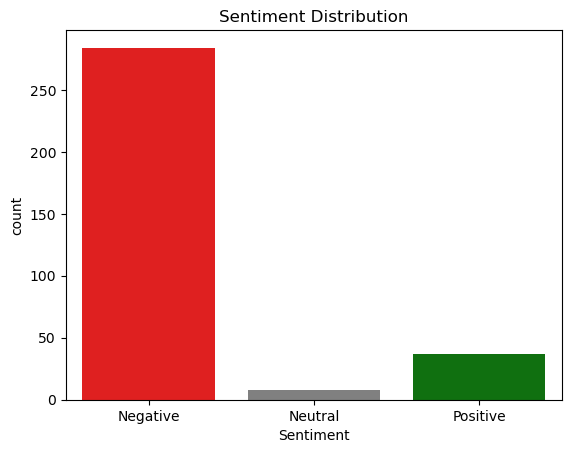

In [12]:
# Plot sentiment distribution
sns.countplot(x=df['Sentiment'], palette=['red', 'gray', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.title("Sentiment Distribution")
plt.show()

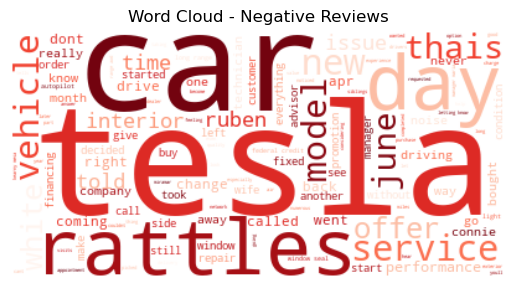

In [62]:
# Word Cloud for Negative Reviews
negative_reviews = " ".join(df2[df2['Sentiment'] == 0]['cleaned_reviews'])
wordcloud = WordCloud(background_color='white', colormap='Reds').generate(negative_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Reviews")
plt.show()

C:\Users\Shivan\AppData\Local\Temp\ipykernel_4636\2387285770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(negative_words), x=list(negative_frequencies), palette='Reds_r')


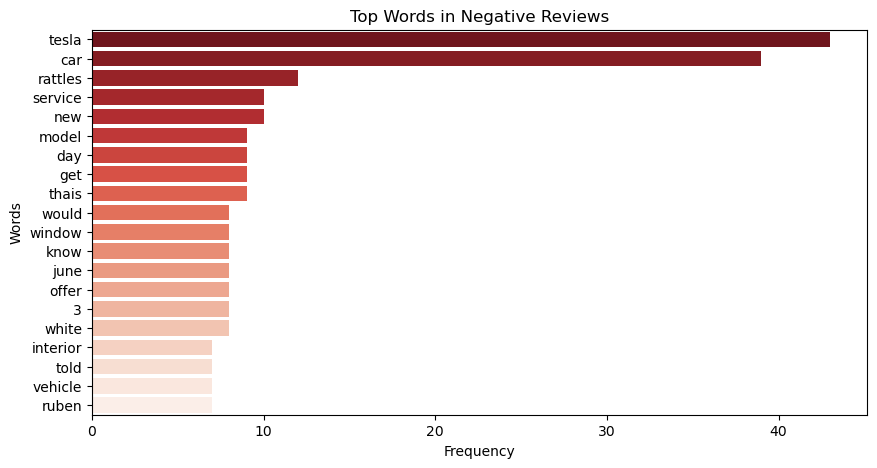

In [63]:
# Horizontal Bar Plot for Negative Review Words
negative_tokens = word_tokenize(negative_reviews.lower())
negative_word_counts = Counter(negative_tokens).most_common(20)
negative_words, negative_frequencies = zip(*negative_word_counts)

plt.figure(figsize=(10, 5))
sns.barplot(y=list(negative_words), x=list(negative_frequencies), palette='Reds_r')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top Words in Negative Reviews")
plt.show()

**Top Words in Negative Reviews**

1. 'tesla', 'car', 'rattles' and 'service' are the top 4 words.

2. 'Rattle' could mean some part of the car could rattle.

3. 'Car' might refer to issues with car itself.

4. 'Service' might refer to customers' experiences at Tesla dealerships

5. "3" could refer to the Tesla model 3

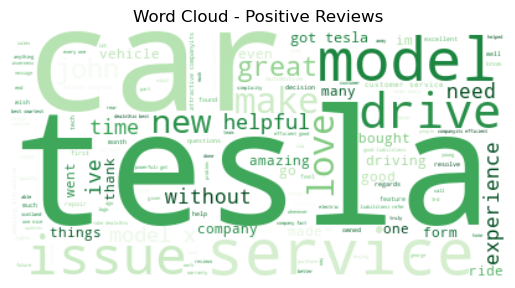

In [64]:
# Word Cloud for Positive Reviews
positive_reviews = " ".join(df2[df2['Sentiment'] == 1]['cleaned_reviews'])
wordcloud = WordCloud(background_color='white', colormap='Greens').generate(positive_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")
plt.show()

C:\Users\Shivan\AppData\Local\Temp\ipykernel_4636\1099141214.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(positive_words), x=list(positive_frequencies), palette='Greens_r')


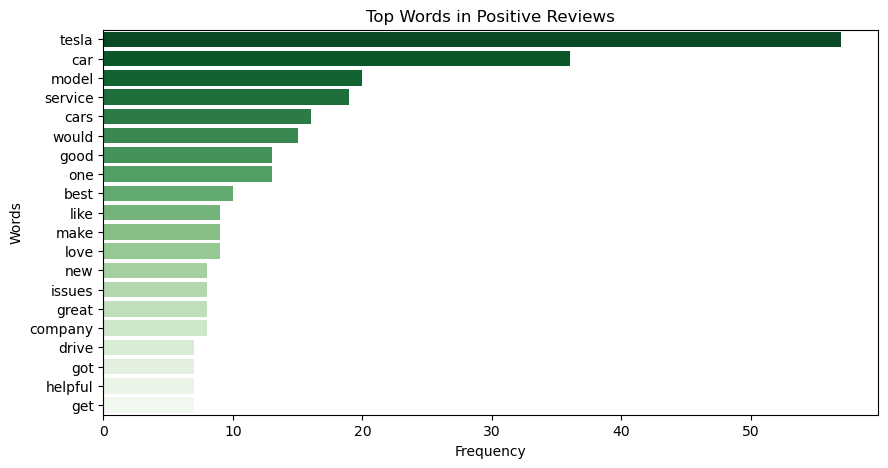

In [65]:
# Horizontal Bar Plot for Negative Review Words
positive_tokens = word_tokenize(positive_reviews.lower())
positive_word_counts = Counter(positive_tokens).most_common(20)
positive_words, positive_frequencies = zip(*positive_word_counts)

plt.figure(figsize=(10, 5))
sns.barplot(y=list(positive_words), x=list(positive_frequencies), palette='Greens_r')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top Words in Positive Reviews")
plt.show()

**Top Words in Positive Reviews**

1. 'tesla', 'car', 'model' and 'service' are the top 4 words.

2. 'model' - could be some good reviews about a model.  I will look further into which tesla model car this is.

3. 'Service' appears in both the good and bad reviews. 

# NRC Emotion Lexicon

Using NRC Emotion Lexicon, which provides emotion-based classification (e.g., joy, anger, fear, sadness). This will help you determine what emotions are present in your Tesla reviews rather than just whether they're positive or negative

In [11]:
# Function to get emotions from NRC Lexicon
def get_emotions(text):
    emotion = NRCLex(text)
    return emotion.top_emotions  # Returns a list of (emotion, score) pairs

# Apply function to the dataset
df['Emotions'] = df['review'].apply(lambda x: get_emotions(str(x)))



In [13]:
df

,Unnamed: 0,review,Sentiment,Emotions
0,0,Still waiting to hear from customer service s....,-1,"[(fear, 0.16666666666666666), (surprise, 0.166..."
1,1,"One of the worst car is Tesla, very expensive ...",-1,"[(positive, 0.3333333333333333)]"
2,2,I can't understand the fixation that few have ...,-1,"[(positive, 0.3)]"
3,3,"Great car, but the customer service side is sh...",-1,"[(positive, 0.6666666666666666)]"
4,4,"I bought a Tesla car 3 Months ago,Unfortunatel...",-1,"[(positive, 0.3333333333333333), (negative, 0...."
...,...,...,...,...
324,324,"Tesla make great cars, I love mine, I am into ...",-1,"[(positive, 0.265625)]"
325,325,"A friend of mine bought a model S ride, it was...",1,"[(positive, 0.5)]"
326,326,"Would never recommend a Tesla to anyone, and w...",-1,"[(anticipation, 0.15384615384615385)]"
327,327,I am disappointed to have to write a negative ...,-1,"[(positive, 0.3188405797101449)]"


C:\Users\Shivan\AppData\Local\Temp\ipykernel_324\3266746849.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="coolwarm")


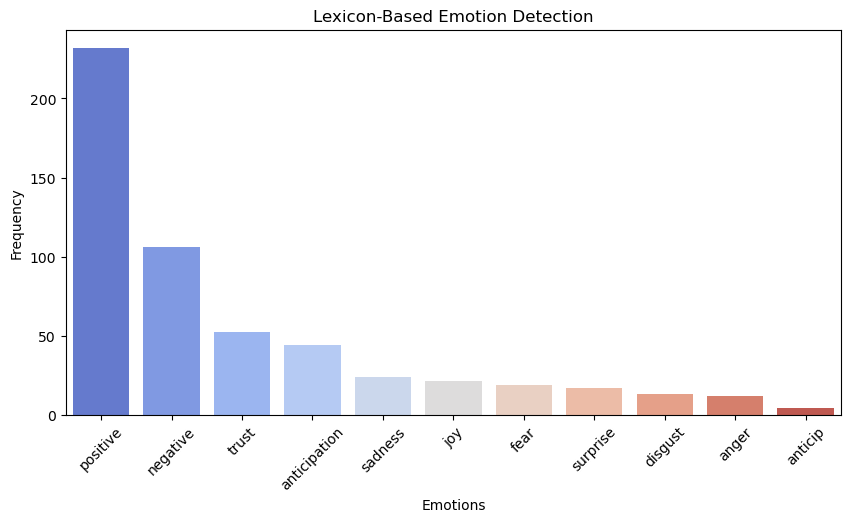

In [12]:
# Convert to a list of all emotions
all_emotions = [emotion for sublist in df['Emotions'] for emotion, score in sublist]

# Count occurrences of each emotion
emotion_counts = pd.Series(all_emotions).value_counts()

# Plot Emotion Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="coolwarm")
plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.title("Lexicon-Based Emotion Detection")
plt.xticks(rotation=45)
plt.show()

**NOTE:** This plot show the emotions experience from all the reviews. This contradicts the Sentiment bar plot which shows there are in fact more negative reviews. Hence i will not consider the NRC Emotion Lexicon in the analysis

# Customer Service/ Experience and Car Service Analysis

## Customer Service

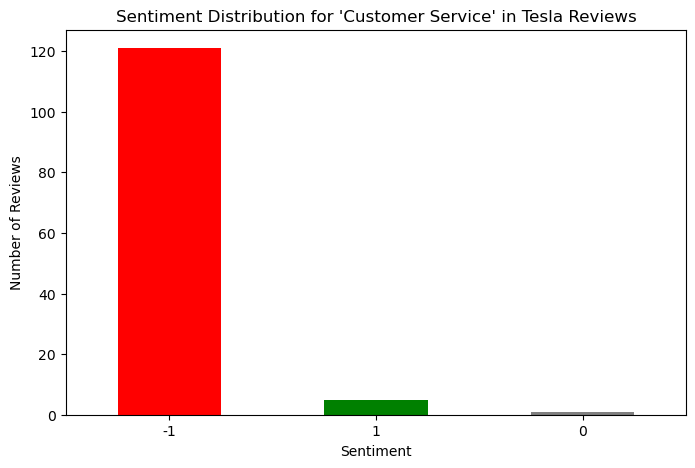

Sentiment
-1    121
 1      5
 0      1
Name: count, dtype: int64

In [116]:
# Filter reviews that mention "service"
customer_service_df= df[df["review"].str.contains("customer service", case=False, na=False)]

# Count sentiment distribution
sentiment_counts = customer_service_df["Sentiment"].value_counts()

# Plot results
plt.figure(figsize=(8,5))
sentiment_counts.plot(kind="bar", color=["red", "green", "gray"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution for 'Customer Service' in Tesla Reviews")
plt.xticks(rotation=0)
plt.show()

# Display sentiment counts
sentiment_counts


## Customer experience

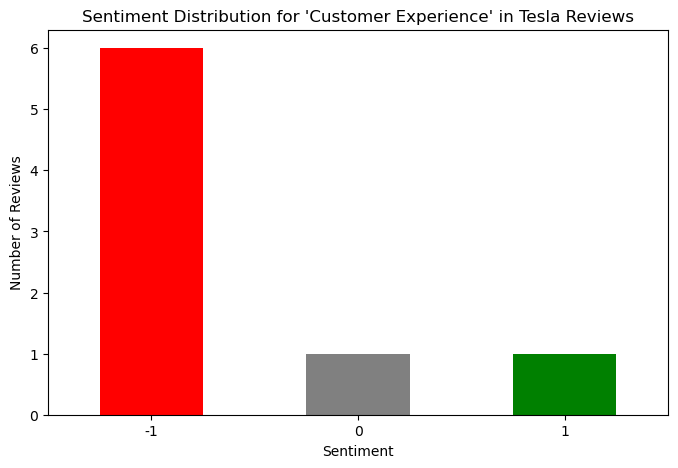

Sentiment
-1    6
 0    1
 1    1
Name: count, dtype: int64

In [108]:
# Filter reviews that mention "customer experience"
customer_experience_df= df[df["review"].str.contains("customer experience", case=False, na=False)]

# Count sentiment distribution
sentiment_counts = customer_experience_df["Sentiment"].value_counts()

# Plot results
plt.figure(figsize=(8,5))
sentiment_counts.plot(kind="bar", color=["red","gray", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution for 'Customer Experience' in Tesla Reviews")
plt.xticks(rotation=0)
plt.show()

# Display sentiment counts
sentiment_counts


## Car Service

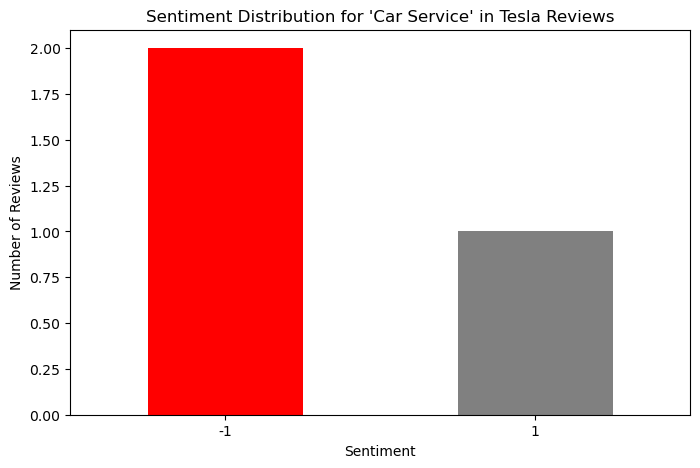

Sentiment
-1    2
 1    1
Name: count, dtype: int64

In [110]:
# Filter reviews that mention "car service"
car_service_df= df[df["review"].str.contains("car service", case=False, na=False)]

# Count sentiment distribution
sentiment_counts = car_service_df["Sentiment"].value_counts()

# Plot results
plt.figure(figsize=(8,5))
sentiment_counts.plot(kind="bar", color=["red","gray", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution for 'Car Service' in Tesla Reviews")
plt.xticks(rotation=0)
plt.show()

# Display sentiment counts
sentiment_counts


In [111]:
# Filter negative Model 3 reviews mentioning "performance"
negative_car_service_df = df[
    (df["Sentiment_Label"] == "Negative") & 
    (df["review"].str.contains("Car Service", case=False, na=False))
]

# Print the full reviews
for i, review in enumerate(negative_car_service_df["review"], 1):
    print(f"\nReview {i}:")
    print(review)


Review 1:
I bought a Tesla car 3 Months ago,Unfortunately that one my biggest mistake to buy this Car ,When I ask some questions about my Car ,They Push back my Service Appointment, If you want a Horrible Car Service Experience buy a Tesla. Still today they did not answer my question what’s Wrong with my Car.

Review 2:
I recently had my car serviced at Tesla Nottingham and unfortunately, I encountered several concerning issues during the process. Despite multiple visits and attempts to address the same issue, I experienced repeated delays and a lack of effective communication from the service center. The recommended replacement of rotors and pads did not resolve the initial problem, and I felt frustrated by the lack of a prompt and satisfactory resolution.Additionally, I found it challenging to get in touch with the service center as my messages were often ignored, and there was no available phone number for direct communication. This lack of accessibility added to the inconvenience 



Bad service experience, Lack of accessibility / communication from service center (messages are bein ignored)

1 instance of an issue with a car not being fixed after it had been service and has led to the cusomters daughter being injured.


## Conclusion


- Overall, there are majority of negative reviews, that being:

    - Customer Service (95%) (121 out of 127 reviews)
    - Customer Experience (76%) (6 out of 8 reviews)
 
Issues include Lack of accessibility / communication from service center (messages are bein ignored).

- With Car Service, there is one instance of an issue with a car not being fixed after it had been service and has led to the cusomters daughter being injured.


# Tesla Car Analysis

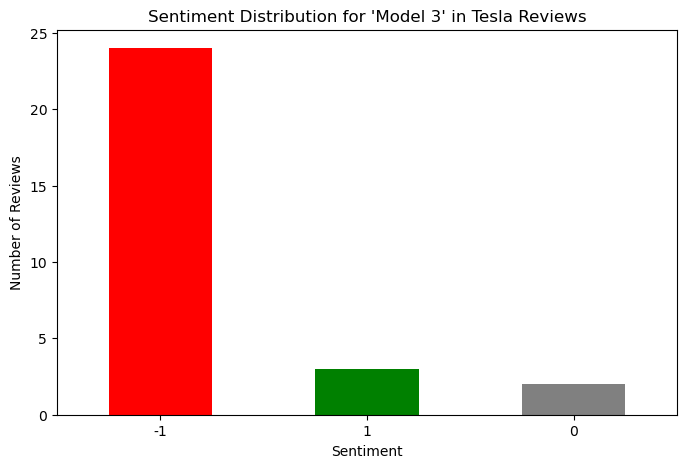

In [74]:
# Filter reviews that mention "Model 3"
model_3_reviews = df[df["review"].str.contains("Model 3", case=False, na=False)]

# Count sentiment distribution
sentiment_counts = model_3_reviews["Sentiment"].value_counts()

# Plot results
plt.figure(figsize=(8,5))
sentiment_counts.plot(kind="bar", color=["red", "green", "gray"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution for 'Model 3' in Tesla Reviews")
plt.xticks(rotation=0)
plt.show()


In [28]:
# Display sentiment counts
sentiment_counts

Sentiment
-1    24
 1     3
 0     2
Name: count, dtype: int64

## Find the positive and negative Bigrams, Trigrams and Quadgrams

In [88]:
# Ensure we're modifying a copy of the original DataFrame
model_3_reviews = df[df["review"].str.contains("Model 3", case=False, na=False)].copy()

# removeing URLs, Punctuation, extra spaces and making text lowercase
model_3_reviews.loc[:, "cleaned_reviews"] = model_3_reviews["review"].apply(lambda x: clean_post(x))

# remove stopwords
model_3_reviews['cleaned_reviews'] = model_3_reviews['cleaned_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

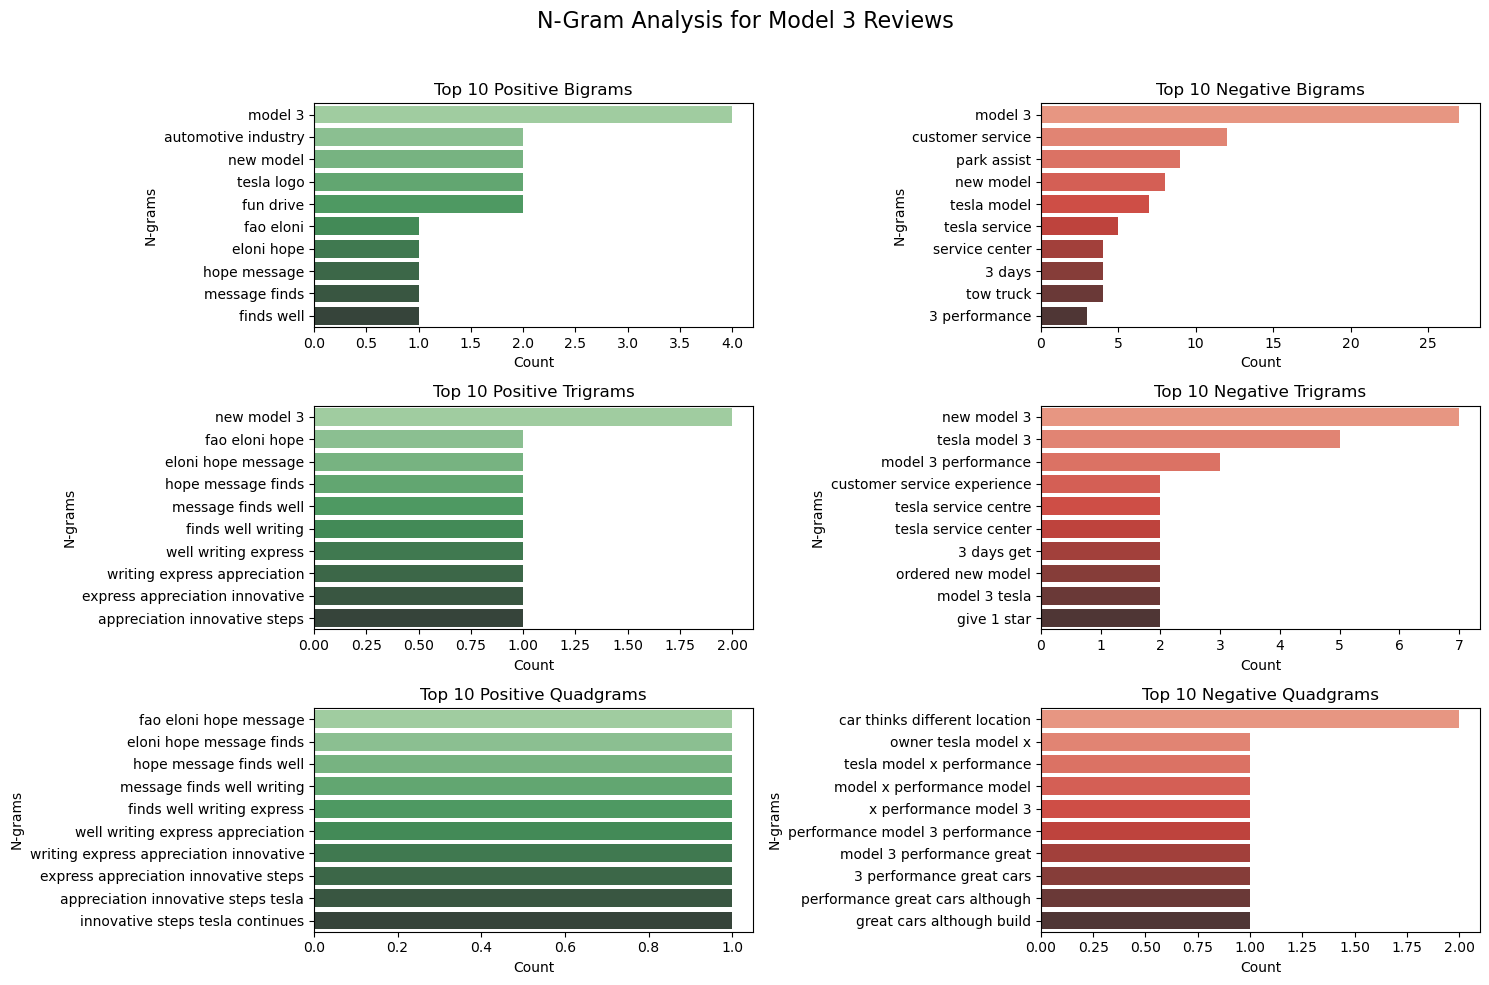

In [98]:
# Function to extract n-grams
def extract_ngrams(texts, n=2):
    """Extract n-grams from a list of texts."""
    all_ngrams = []
    for text in texts:
        tokens = word_tokenize(str(text).lower())  # Convert text to lowercase & tokenize
        if len(tokens) >= n:  # Ensure enough words to form n-grams
            all_ngrams.extend(list(ngrams(tokens, n)))
    return Counter(all_ngrams).most_common(10) if all_ngrams else []  # Return empty list if no n-grams

# Function to plot n-grams
def plot_ngrams(ax, ngrams_count, title, color):
    """Plot n-gram frequency as a horizontal bar chart in a subplot."""
    if not ngrams_count:
        ax.set_title(f"No {title.lower()} found")
        ax.axis("off")  # Hide axis if no data
        return
    
    ngrams, counts = zip(*ngrams_count)  # Unpack tuples
    ngrams = [" ".join(ngram) for ngram in ngrams]  # Convert tuples to strings
    
    sns.barplot(x=counts, y=ngrams, ax=ax, palette=color)
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("N-grams")


# Extract reviews based on Sentiment
positive_reviews = model_3_reviews[model_3_reviews["Sentiment_Label"] == "Positive"]["cleaned_reviews"]
negative_reviews = model_3_reviews[model_3_reviews["Sentiment_Label"] == "Negative"]["cleaned_reviews"]

# Extract n-grams
positive_bigrams = extract_ngrams(positive_reviews, 2)
negative_bigrams = extract_ngrams(negative_reviews, 2)

positive_trigrams = extract_ngrams(positive_reviews, 3)
negative_trigrams = extract_ngrams(negative_reviews, 3)

positive_quadgrams = extract_ngrams(positive_reviews, 4)
negative_quadgrams = extract_ngrams(negative_reviews, 4)

# Plot all n-grams in a 2x3 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle("N-Gram Analysis for Model 3 Reviews", fontsize=16)

# Bigrams
plot_ngrams(axes[0, 0], positive_bigrams, "Top 10 Positive Bigrams", "Greens_d")
plot_ngrams(axes[0, 1], negative_bigrams, "Top 10 Negative Bigrams", "Reds_d")

# Trigrams
plot_ngrams(axes[1, 0], positive_trigrams, "Top 10 Positive Trigrams", "Greens_d")
plot_ngrams(axes[1, 1], negative_trigrams, "Top 10 Negative Trigrams", "Reds_d")

# Quadgrams
plot_ngrams(axes[2, 0], positive_quadgrams, "Top 10 Positive Quadgrams", "Greens_d")
plot_ngrams(axes[2, 1], negative_quadgrams, "Top 10 Negative Quadgrams", "Reds_d")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


There seems to be positive and negative reviews on the Tesla Model 3. 

There could be issuse with 'park assist' , 'performance', on the cars, possibly on the Tesla Model 3 

### Park assist feature reviews

In [99]:
# Filter negative Model 3 reviews mentioning "performance"
performance_issues_df = df[
    (df["Sentiment_Label"] == "Negative") & 
    (df["review"].str.contains("park assist", case=False, na=False))
]

# Print the full reviews
for i, review in enumerate(performance_issues_df["review"], 1):
    print(f"\nReview {i}:")
    print(review)


Review 1:
Very Unhappy with the new Model 3 Dual Motor Long Range and the service from Tesla up to now. Our concerns / issues still outstanding as of today a week on from the last email response from Tesla (I have managed to speak with them today and hope this leads to a satisfactory resolution):- Delivery - when I spoke with the Brent Cross team they told me our car would be delivered on the back of a flat bed truck (I specifically asked this question). When it actually arrived, it had been driven 30 miles - if driven by road this should only be 5.7 miles BUT according to what I was told it should have been minimal for loading and unloading. I was prepared to overlook this previously but with everything that has happened since we no longer are prepared to accept that. A new car should not have 30 miles on the clock and I should not have been lied to by the Brent Cross delivery team.- Rear Park Assist - an incident happened on Sunday 3 March at 7:30pm - was very concerning as there we

### Car Performace reviews

In [76]:
df["Sentiment_Label"] = df["Sentiment"].apply(categorize_sentiment)

In [78]:
# Filter negative Model 3 reviews mentioning "performance"
performance_issues_df = df[
    (df["Sentiment_Label"] == "Negative") & 
    (df["review"].str.contains("performance", case=False, na=False))
]

# Print the full reviews
for i, review in enumerate(performance_issues_df["review"], 1):
    print(f"\nReview {i}:")
    print(review)


Review 1:
Owner of Tesla Model X Performance and Model 3 Performance. Both great cars although the build quality needs to improve as they far behind premium German cars. The major downside with Tesla is the customer service which is, in my experience, very poor. The mobile service visits are great and convenient, but I have had an issue with nearly every visit to a Tesla Service Centre. If you ask for a waiting appointment then expect to be sitting there all day!

Review 2:
First off I have a model 3 performance and I really like my car but the service you get from your local service center sucks they never call you back I’ve called 3 days in a row and no one ever calls you back last year had to have the ball joint replaced they never called to let me know when parts were in for repair I had to actually go their in person to get my car in the shop and now trying to order a new windshield and no one will call back so aggravated I left them a rude message by the way it’s the shop locate

After having a look at the reviews, there is no probelms with the cars performance. the word "Performance" appears alot because it refers to the Tesla Model X Performance and Model 3 Performance cars and not any performance issues. the main issues just seem to stem from customer services

### Rattle noise

In [117]:
# Filter negative Model 3 reviews mentioning "performance"
performance_issues_df = df[
    (df["Sentiment_Label"] == "Negative") & 
    (df["review"].str.contains("rattle", case=False, na=False))
]

# Print the full reviews
for i, review in enumerate(performance_issues_df["review"], 1):
    print(f"\nReview {i}:")
    print(review)


Review 1:
Let’s start with ratings. Only give 1 star because I had to. Would be 0* if could. Tesla model 3 is the biggest load crap iv ever owned and iv owned some dodgy cars in my many years. Iv owned it for 6 months driven less than 500miles it’s been in Tesla 5 times, spoiler falling of, bumper has swelling in it (large bumps) can’t connect to Wi-Fi, can’t connect to phone, car thinks it’s at a different location on phone gps, rattles in car, tesla just squirted silicone behind panel to bodge, still rattles, glass on roof doesn’t fit properly, noise from front suspension, first visit to service center they dented car, second time they replaced antenna, black hand marks all over roof lining, broken clips left on floor of car ( didn’t replace as loose door card now, I can go on and on and on and on, Just keep getting crap excuses, fobbing me of, the car is not fit for purpose, I will say this is my experience from BRISTOL TESLA SERVICE CENTRE, can’t comment on other areas but assume 

There are 3 instance of the car rattle sound coming from the vehicle

## Conclusion

- There are indeed 2 issues with the park assist:

1. the seems to be a malfunction with the car sensors as the car did not beep when the cusomter was reversing close to an object.
2. Another customer experienced the park assist being faulty 3 times.

- After having a look at the reviews, there is no problems with the cars performance. The word "Performance" appears alot because it refers to the Tesla Model X Performance or Model 3 Performance cars and not any performance issues. The main issues just seem to stem from customer service.

- There are 3 instance of customers who reported a rattle sound coming from some vehicle.